## <h2> Teoria de Controle -> Prova 2 - Parte 3
## <h2> Projeto de controlador via resposta em frequência
### <h3> Alunos: Gabriel M. Duarte e Loren R. Menezes.

### <h3 style="text-align: center;"> Questão (1)

In [1]:
import numpy as np
import sympy as sp
import control as ct
import matplotlib.pyplot as plt

##### <h5> Sistema

In [2]:
s = ct.tf('s')
G = 6/(s*(10*s+1))
G

TransferFunction(array([6]), array([10,  1,  0]))

##### <h5> Especificações

In [3]:
kv = 20
MUP = 25

##### <h5> Cálculo de K

In [4]:
s_ = sp.Symbol('s_')
G_ = 6/(s_*(10*s_+1))

K = kv / sp.limit(s_*G_, s_, 0)
print("K =", K.evalf())

K = 3.33333333333333


##### <h5> Cálculo da margem de fase desejada 

In [5]:
zeta = -np.log(MUP/100)/(np.sqrt(np.pi**2+np.log(MUP/100)**2))
PHI_m_desejado = np.degrees(np.arctan((2*zeta)/(np.sqrt(-2*zeta**2+np.sqrt(1+4*zeta**4)))))
print("Margem de fase desejada = ", PHI_m_desejado)

Margem de fase desejada =  43.46300666885529


##### <h5> Obtenção da margem de fase atual (sem controlador)

Margem de fase inicial =  4.038790526592663


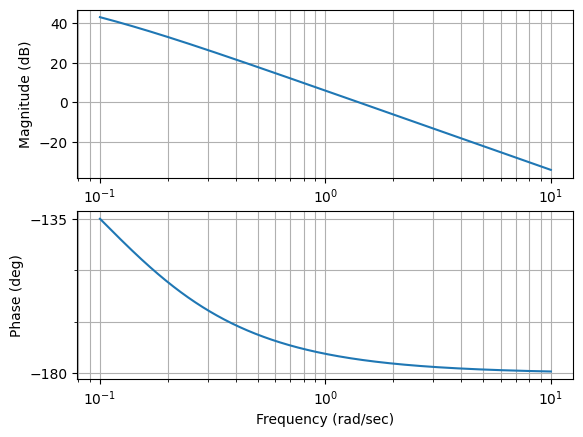

In [6]:
mag, phase, w = ct.bode(float(K)*G, omega_limits=[1e-1, 1e1], dB=True, Hz=False, deg=True, plot=True)

mag = 20*np.log10(mag)
phase = np.degrees(phase)

for i in range(len(w)):
    if mag[i] < 0:
        freq_0dB = w[i]
        PHI_m_inicial = 180 + phase[i]
        break

print("Margem de fase inicial = ", PHI_m_inicial)

##### <h5> Cálculo da margem de fase a ser fornecida pelo controlador C(s)

In [7]:
folga = 10

PHI_m_controlador = (PHI_m_desejado - PHI_m_inicial) + folga

print("Contribuição de fase = ", PHI_m_controlador)

Contribuição de fase =  49.42421614226263


##### <h5> Cálculo da nova frequência de cruzamento de ganho

In [8]:
alpha = (1-np.sin(np.radians(PHI_m_controlador)))/(1+np.sin(np.radians(PHI_m_controlador)))

aux = -20*np.log10(1/np.sqrt(alpha))

for i in range(len(w)):
    if mag[i] < aux:
        new_freq_0dB = w[i]
        break

print("wc = ", new_freq_0dB)

wc =  2.3300614106969246


##### <h5> Cálculo de T

In [9]:
T = 1/(np.sqrt(alpha)*new_freq_0dB)
print("T = ", T)

T =  1.1609599553688252


##### <h5> Cálculo do controlador

In [10]:
z = 1/T
p = 1/(alpha*T)
kc = float(K/alpha)

C = kc*((s+z)/(s+p))
C

TransferFunction(array([24.39203082, 21.01022581]), array([1.        , 6.30306774]))

##### <h5> Diagrama de bode da malha fechada

Margem de fase alcançada =  51.89272938387356


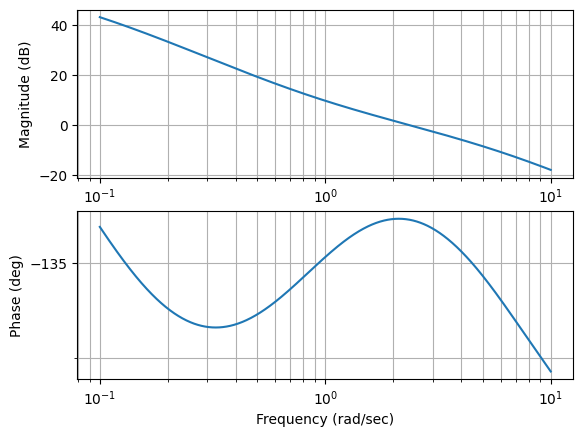

In [11]:
mag, phase, w = ct.bode(C*G, omega_limits=[1e-1, 1e1], dB=True, Hz=False, deg=True, plot=True)

mag = 20*np.log10(mag)
phase = np.degrees(phase)

mag = mag[::-1]
phase = phase[::-1]

for i in range(len(w)):
    if mag[i] > 0:
        freq_0dB = w[i]
        PHI_m_alcancada = 180 + phase[i]
        break

print("Margem de fase alcançada = ", PHI_m_alcancada)

##### <h5> A margem de fase alcançada é superior à margem de fase desejada, cumprindo com o requisito de projeto.

##### <h5> Resposta ao degrau da malha fechada

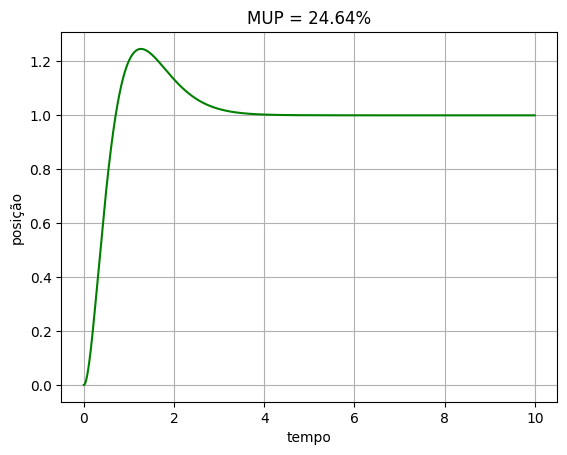

In [12]:
MF = ct.feedback(C*G)

time = np.arange(0, 10, 0.001)

t, y = ct.step_response(MF, T=time)

MUP_real = ((np.max(y)-y[-1])/y[-1])*100

plt.title('MUP = ' + str(round(MUP_real,2)) + '%')
plt.plot(time, y, color='green')
plt.xlabel('tempo')
plt.ylabel('posição')
plt.grid()

##### <h5> O overshoot é inferior à 25%, conforme desejado.

##### <h5> Resposta à rampa da malha fechada

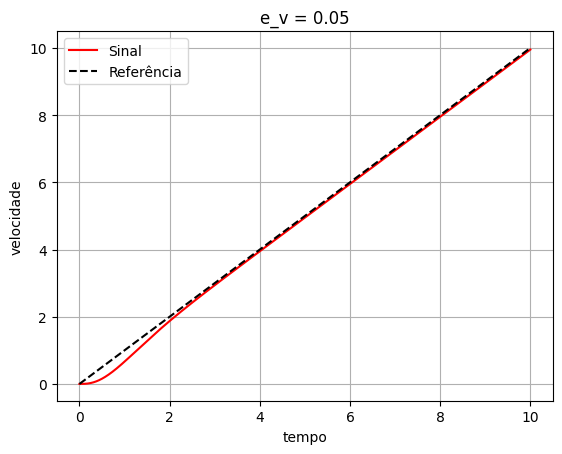

In [13]:
t, y = ct.forced_response(MF, T=time, U=time)

erro_velocidade = time[-1]-y[-1]

plt.title('e_v = ' + str(round(erro_velocidade,4)))
plt.plot(time, y, color='red', label='Sinal')
plt.plot(time, time, color='black', label='Referência', linestyle='--')
plt.xlabel('tempo')
plt.ylabel('velocidade')
plt.legend()
plt.grid()

##### <h5> O erro de velocidade é igual a 0.05, conforme desejado.

### <h3 style="text-align: center;"> Questão (2)

##### <h5> A ideia aqui será avaliar o lugar das raízes com os polos desejados, junto ao zero do controlador, a fim de verificar seu efeito sobre a malha fechada.

Polos de malha fechada: 
(-2.29+1.29j)
(-2.29-1.29j)
(-1.82+0j)


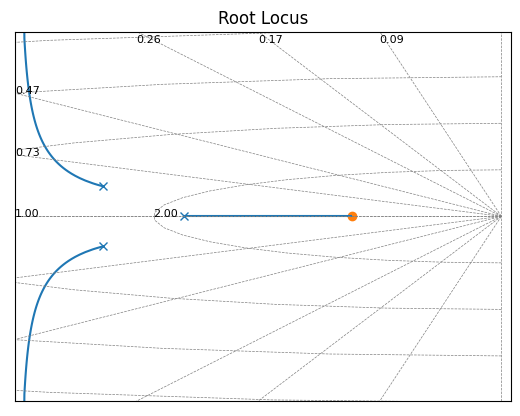

In [14]:
ct.root_locus(MF)

plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

polos_MF = np.round(ct.poles(MF),2)
print("Polos de malha fechada: ")
for i in range(len(polos_MF)):
    print(polos_MF[i])

Zero do controlador:
(-0.8613561521872735+0j)


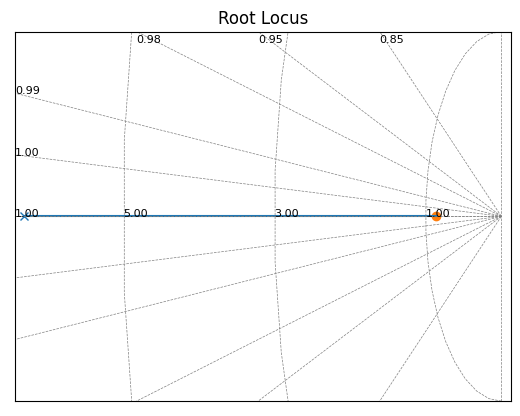

In [15]:
ct.root_locus(C)

plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)

print("Zero do controlador:")
print(ct.zeros(C)[0])

##### <h5> Como o zero do controlador está próximo de um dos polos desejados de malha fechada, conclui-se que tal zero influencia negativamente as especificações de projeto. Nesse sentido, quanto mais próximo o zero do controlador estiver dos polos desejados, maior será o overshoot na resposta ao degrau.

##### <h5> Tanto é que, dependendo da folga escolhida, como por exemplo 5°, a margem de fase alcançada é superior à desejada, porém o overshoot não é atendido.